In [25]:
# KOMÓRKA #1 — IMPORTY
import os                          # operacje systemowe/ścieżki
import sys                         # system (wersja Pythona itp.)
import hashlib                     # sumy kontrolne (hashy)
import time                        # pomiary czasu
from typing import Optional        # typowanie
import cv2                         # obsługa kamery/wideo (OpenCV)
import numpy as np                 # operacje na macierzach/obrazach
import torch                       # PyTorch (model emocji)
import torch.nn as nn              # sieci neuronowe
from torchvision import transforms # transformacje obrazów
import matplotlib.pyplot as plt    # PODGLĄD miniatur kamer
from pathlib import Path           # obsługa ścieżek plików
from torch.serialization import add_safe_globals # bezpieczne ładowanie modeli PyTorch
from deepface import DeepFace      # do wykrywania twarzy/emocji (alternatywa)

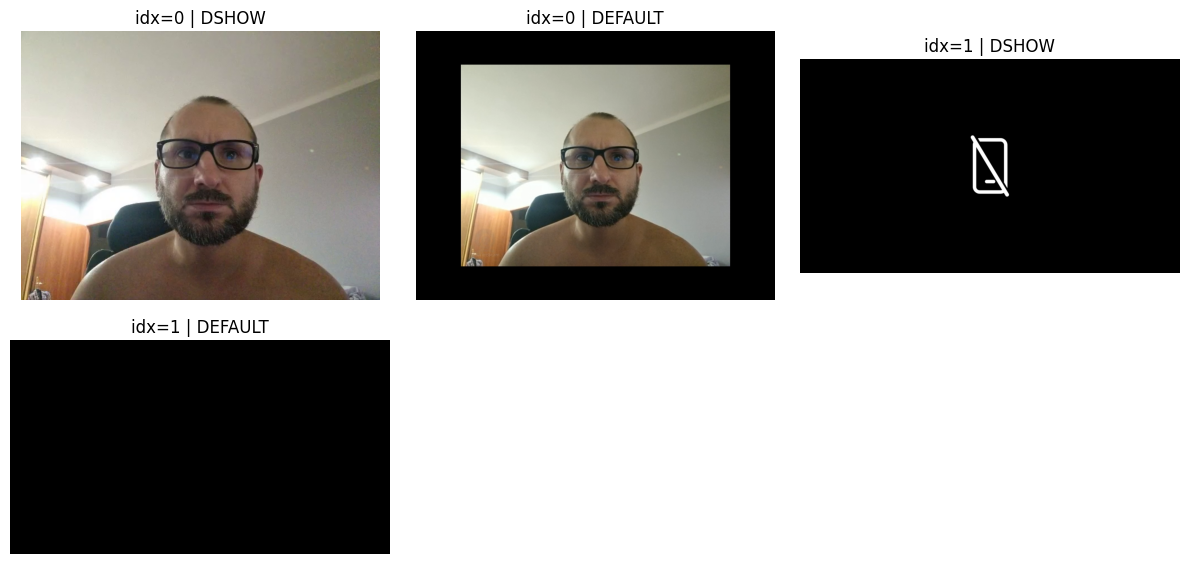

Kandydaci: [(0, 'DSHOW'), (0, 'DEFAULT'), (1, 'DSHOW'), (1, 'DEFAULT')]


In [26]:
# Skanuje indeksy 0..max_index, pokazuje miniatury z kamer i zwraca listę kandydatów
def _grab_frame(idx: int, api: int | None, warmup: int = 5):
    cap = cv2.VideoCapture(idx, api) if api is not None else cv2.VideoCapture(idx)
    if not cap.isOpened():
        return None
    # krótka rozgrzewka (niektóre sterowniki oddają czarną 1. klatkę)
    for _ in range(warmup):
        ok, _ = cap.read()
        if not ok:
            cap.release()
            return None
    ok, frame = cap.read()
    cap.release()
    if not ok or frame is None:
        return None
    return frame

def scan_cameras(max_index: int = 6, try_both_apis: bool = True):
    """
    Zwraca listę: [(idx, api_name, frame_rgb), ...]
    api_name ∈ {"DSHOW","DEFAULT"}
    """
    candidates = []
    api_options = [("DSHOW", cv2.CAP_DSHOW)] if try_both_apis else [("DEFAULT", None)]
    if try_both_apis:
        api_options.append(("DEFAULT", None))

    for i in range(max_index + 1):
        for api_name, api in api_options:
            frame = _grab_frame(i, api)
            if frame is not None:
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                candidates.append((i, api_name, rgb))
                # nie przerywamy — pokazujemy wszystkie źródła (masz 2 telefony)
    return candidates

cands = scan_cameras(max_index=6, try_both_apis=True)

# Wizualizacja miniatur
if not cands:
    print("Nie znaleziono żadnej działającej kamery w indeksach 0..6.")
else:
    n = len(cands)
    cols = 3
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(4*cols, 3*rows))
    for k, (idx, api_name, rgb) in enumerate(cands, start=1):
        plt.subplot(rows, cols, k)
        plt.imshow(rgb)
        plt.title(f"idx={idx} | {api_name}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Lista kandydatów do szybkiej referencji:
cands_summary = [(idx, api) for (idx, api, _) in [(i, a, f) for i,a,f in cands]]
print("Kandydaci:", cands_summary)

## USTAW INDEX KAMERY - DOMYŚLNIE 0

OK — jedna klatka: (480, 640, 3)


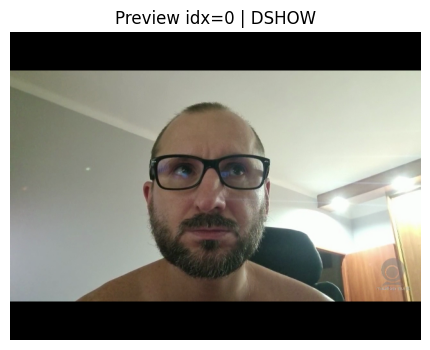

In [27]:
# USTAW tutaj wybraną parę z listy miniatur (patrz tytuły na obrazkach):
CAM_INDEX = 0       # <- wpisz właściwy idx z miniatur
CAM_API_NAME = "DSHOW"  # "DSHOW" albo "DEFAULT"

CAM_API = cv2.CAP_DSHOW if CAM_API_NAME.upper() == "DSHOW" else None

# Szybki test: jedna klatka + info o rozmiarze
frame = _grab_frame(CAM_INDEX, CAM_API)
assert frame is not None, f"Nie udało się pobrać klatki z idx={CAM_INDEX}, api={CAM_API_NAME}"
print("OK — jedna klatka:", frame.shape)

# podgląd w matplotlib (lustrzane jak w Iriun)
plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(cv2.flip(frame, 1), cv2.COLOR_BGR2RGB))
plt.title(f"Preview idx={CAM_INDEX} | {CAM_API_NAME}")
plt.axis("off")
plt.show()

⚠️ MediaPipe process failed ('SymbolDatabase' object has no attribute 'GetPrototype'). Falling back to HaarCascade.


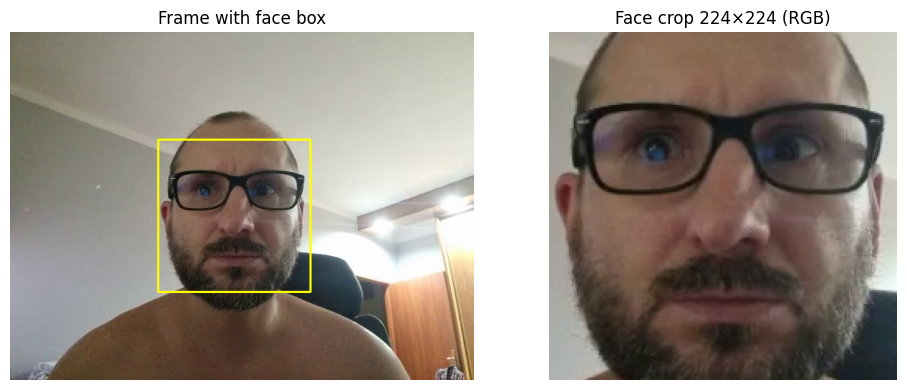

In [28]:
# --- DETEKCJA TWARZY (MP -> fallback Haar), PODGLĄD I CROP 224x224 ---

# 0) Spróbuj wczytać MediaPipe; jeśli są problemy z protobuf 6.x, od razu fallback
mp_fd = None
try:
    import mediapipe as mp  # może polecieć na konflikt protobuf
    mp_fd = mp.solutions.face_detection
except Exception as e:
    print(f"⚠️ MediaPipe import failed ({e}). Falling back to HaarCascade.")
    mp_fd = None

# 1) Jedna klatka z kamery
try:
    api_flag = cv2.CAP_DSHOW if ('CAM_API_NAME' in globals() and str(CAM_API_NAME).upper() == "DSHOW") else None
except Exception:
    api_flag = None

frame_bgr = _grab_frame(CAM_INDEX, api_flag)
assert frame_bgr is not None, f"Cannot read a frame from idx={CAM_INDEX} ({globals().get('CAM_API_NAME','AUTO')})."

# 2) Mirror (jak w Iriun)
frame_bgr = cv2.flip(frame_bgr, 1)
H, W = frame_bgr.shape[:2]

# 3) Detekcja twarzy: najpierw próbuj MediaPipe, w razie problemu -> Haar
have_box = False
x1 = y1 = x2 = y2 = 0

if mp_fd is not None:
    try:
        with mp_fd.FaceDetection(model_selection=0, min_detection_confidence=0.4) as fd:
            frame_rgb_full = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            res = fd.process(frame_rgb_full)
        if res and res.detections:
            det = res.detections[0]
            bb = det.location_data.relative_bounding_box
            x1 = max(0, int(bb.xmin * W))
            y1 = max(0, int(bb.ymin * H))
            x2 = min(W, int((bb.xmin + bb.width)  * W))
            y2 = min(H, int((bb.ymin + bb.height) * H))
            have_box = (x2 > x1) and (y2 > y1)
        else:
            print("ℹ️ MediaPipe: no detections. Falling back to HaarCascade.")
    except Exception as e:
        print(f"⚠️ MediaPipe process failed ({e}). Falling back to HaarCascade.")

if not have_box:
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    faces = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")\
             .detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    if len(faces) == 0:
        raise RuntimeError("No face detected (HaarCascade). Improve lighting / face the camera.")
    # największa twarz
    x, y, w, h = max(list(faces), key=lambda b: b[2]*b[3])
    x1, y1, x2, y2 = x, y, x + w, y + h

# 4) Crop twarzy i konwersja do RGB
face_bgr = frame_bgr[y1:y2, x1:x2]
assert face_bgr.size > 0, "Detected box is empty — check the frame dimensions."
face_rgb = cv2.cvtColor(face_bgr, cv2.COLOR_BGR2RGB)

# 5) Resize do 224×224 (typowo dla modeli)
face_224 = cv2.resize(face_rgb, (224, 224), interpolation=cv2.INTER_AREA)

# 6) Podgląd: pełna klatka z ramką + crop
frame_vis = frame_bgr.copy()
cv2.rectangle(frame_vis, (x1, y1), (x2, y2), (0, 255, 255), 2)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(frame_vis, cv2.COLOR_BGR2RGB)); plt.title("Frame with face box"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(face_224); plt.title("Face crop 224×224 (RGB)"); plt.axis("off")
plt.tight_layout(); plt.show()

# 7) Zapisz do zmiennych „na później”
FACE_CROP_224 = face_224      # RGB 224×224
FACE_BBOX     = (x1, y1, x2, y2)


In [29]:
from torchvision.models import resnet18, ResNet18_Weights # model ResNet18

def get_model(num_classes: int,
              pretrained: bool = True,
              dropout_p: float = 0.2,
              freeze_backbone: bool = False) -> nn.Module:
    weights = ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
    model = resnet18(weights=weights)

    if freeze_backbone:
        for p in model.parameters():
            p.requires_grad = False

    in_features = model.fc.in_features  # RN18: 512
    model.fc = nn.Sequential(
        nn.Dropout(p=dropout_p),
        nn.Linear(in_features, num_classes)
    )
    return model

In [30]:
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

print("Transformaty gotowe.")

Transformaty gotowe.


In [31]:
import torch.optim as optim        # optymalizatory PyTorch

model = get_model(num_classes=7, pretrained=True, dropout_p=0.2, freeze_backbone=False)

optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
# albo różnicowane LR:
# head_params = list(model.fc.parameters())
# backbone_params = [p for n,p in model.named_parameters() if not n.startswith('fc.')]
# optimizer = optim.AdamW([
#     {'params': backbone_params, 'lr': 1e-4},
#     {'params': head_params, 'lr': 1e-3}
# ], weight_decay=1e-4)

In [32]:
def ensure_weights_local(
    local_path: str,
    hf_repo_id: str,
    hf_filename: str,
    hf_token: Optional[str] = None,
    expected_sha256: Optional[str] = None,
) -> str:
    """
    Upewnia się, że plik wag istnieje lokalnie. Jeśli nie istnieje – pobiera z Hugging Face.
    
    Args:
        local_path: pełna ścieżka docelowa do pliku wag (np. r"d:\...\weights\resnet18_fer2013_best.pth")
        hf_repo_id: repo na HF (np. "user_or_org/project")
        hf_filename: nazwa pliku w repo (np. "resnet18_fer2013_best.pth" lub "weights/resnet18_best.pth")
        hf_token: opcjonalny token dla repo prywatnych (str lub None)
        expected_sha256: opcjonalna suma SHA-256 do weryfikacji integralności

    Returns:
        Ścieżka do lokalnego pliku wag (string).

    Raises:
        FileNotFoundError: gdy nie udało się pobrać pliku.
        ValueError: gdy weryfikacja SHA-256 nie powiedzie się.
    """
    local_path = Path(local_path)
    local_path.parent.mkdir(parents=True, exist_ok=True)

    def _sha256(path: Path) -> str:
        h = hashlib.sha256()
        with path.open("rb") as f:
            for chunk in iter(lambda: f.read(1024 * 1024), b""):
                h.update(chunk)
        return h.hexdigest()

    # 1) Jeśli istnieje lokalnie — ewentualnie zweryfikuj hash i wyjdź
    if local_path.exists():
        if expected_sha256:
            got = _sha256(local_path)
            if got.lower() != expected_sha256.lower():
                raise ValueError(
                    f"Plik '{local_path}' istnieje, ale SHA-256 się nie zgadza.\n"
                    f"  expected: {expected_sha256}\n  got:      {got}"
                )
        return str(local_path)

    # 2) Brak lokalnie — pobierz z HF do cache
    try:
        cache_path = hf_hub_download(
            repo_id=hf_repo_id,
            filename=hf_filename,
            token=hf_token,
            resume_download=True,
        )
    except Exception as e:
        raise FileNotFoundError(
            f"Nie udało się pobrać z Hugging Face: {hf_repo_id}/{hf_filename}\n"
            f"Powód: {e}\n"
            f"Sprawdź: nazwy, uprawnienia (token), istnienie pliku w repo."
    )

    # 4) Skopiuj (rename bezpieczny między dyskami -> write/read)
    data = cache_path.read_bytes()
    local_path.write_bytes(data)

    return str(local_path)

In [33]:
# >>> WSTAW SWOJE KONKRETNE DANE <<<
os.environ["HF_REPO_ID"]  = "twoj_user/face-emotion-weights"   # np. "crispotter/face-emotion-weights"
os.environ["HF_FILENAME"] = "resnet18_fer2013_best.pth"        # dokładna nazwa pliku w repo
# os.environ["HF_TOKEN"]  = "hf_xxx"                            # jeśli repo prywatne
# os.environ["HF_SHA256"] = "..."                               # opcjonalnie: suma kontrolna

# Krótka diagnostyka:
print("HF_REPO_ID =", os.getenv("HF_REPO_ID"))
print("HF_FILENAME =", os.getenv("HF_FILENAME"))
print("HF_TOKEN set? ", "YES" if os.getenv("HF_TOKEN") else "NO")

HF_REPO_ID = twoj_user/face-emotion-weights
HF_FILENAME = resnet18_fer2013_best.pth
HF_TOKEN set?  NO


In [34]:
# Domyślne ścieżki/zmienne (zmień pod swój projekt)
WEIGHTS_LOCAL_PATH = r"d:\Programowanie\Python\Projects\face_emotion_detector_best\weights\resnet18-5c106cde.pth"

# Zmiennie środowiskowe (ustaw wcześniej w systemie lub tutaj przed wywołaniem)
HF_REPO_ID   = os.getenv("HF_REPO_ID")       # np. "twoj_user/face-emotion-weights"
HF_FILENAME  = os.getenv("HF_FILENAME")      # np. "resnet18_fer2013_best.pth"
HF_TOKEN     = os.getenv("HF_TOKEN")         # jeśli repo prywatne, inaczej None
HF_SHA256    = os.getenv("HF_SHA256")        # opcjonalnie: oczekiwany hash

# Wywołanie
weights_path = ensure_weights_local(
    local_path=WEIGHTS_LOCAL_PATH,
    hf_repo_id=HF_REPO_ID,
    hf_filename=HF_FILENAME,
    hf_token=HF_TOKEN,
    expected_sha256=HF_SHA256
)
print("Wagi gotowe pod:", weights_path)

Wagi gotowe pod: d:\Programowanie\Python\Projects\face_emotion_detector_best\weights\resnet18-5c106cde.pth


In [35]:
p = Path(WEIGHTS_LOCAL_PATH)
assert p.exists() and p.is_file(), f"Brak pliku wag: {p}"

def sha256(path: Path) -> str:
    h = hashlib.sha256()
    with path.open("rb") as f:
        for chunk in iter(lambda: f.read(1024*1024), b""):
            h.update(chunk)
    return h.hexdigest()

print("Plik OK, rozmiar:", p.stat().st_size, "B")
print("SHA-256:", sha256(p))

Plik OK, rozmiar: 46827520 B
SHA-256: 5c106cde386e87d4033832f2996f5493238eda96ccf559d1d62760c4de0613f8


In [36]:
# Wczytaj plik .pth w legacy formacie (oficjalny PyTorch) — świadomie wyłączamy weights_only
try:
    sd_obj = torch.load(WEIGHTS_LOCAL_PATH, map_location="cpu", weights_only=False)
except TypeError:
    # Dla starszych wersji torch bez parametru weights_only
    sd_obj = torch.load(WEIGHTS_LOCAL_PATH, map_location="cpu")

# Różne warianty zapisu: czysty state_dict albo checkpoint z kluczem 'state_dict'/'model'
if isinstance(sd_obj, dict) and "state_dict" in sd_obj and isinstance(sd_obj["state_dict"], dict):
    sd = sd_obj["state_dict"]
elif isinstance(sd_obj, dict) and all(isinstance(v, torch.Tensor) for v in sd_obj.values()):
    sd = sd_obj  # czysty state_dict
elif isinstance(sd_obj, dict) and "model" in sd_obj and isinstance(sd_obj["model"], dict):
    sd = sd_obj["model"]
else:
    raise ValueError("Nie rozpoznano formatu wag: to nie wygląda na state_dict.")

# Usuwanie prefiksu 'module.' jeśli wagi zapisano z DataParallel
first_key = next(iter(sd.keys()))
if first_key.startswith("module."):
    sd = {k.replace("module.", "", 1): v for k, v in sd.items()}

print("Załadowano state_dict z", len(sd), "kluczami.")

Załadowano state_dict z 102 kluczami.


In [37]:
m_test = resnet18(weights=None)
missing, unexpected = m_test.load_state_dict(sd, strict=False)
print("missing:", len(missing), "→", missing[:6])
print("unexpected:", len(unexpected), "→", unexpected[:6])

# Spodziewamy się fc dla 1000 klas (ImageNet)
fc_w = sd.get("fc.weight", None)
fc_b = sd.get("fc.bias", None)
assert fc_w is not None and fc_b is not None, "Brakuje kluczy fc.weight/fc.bias"
print("fc.weight shape:", tuple(fc_w.shape))  # (1000, 512)
print("fc.bias   shape:", tuple(fc_b.shape))  # (1000,)
assert fc_w.shape == (1000, 512) and fc_b.shape == (1000,), "To nie wygląda na oficjalne wagi ImageNet."

print("conv1.weight:", tuple(sd["conv1.weight"].shape))                 # (64, 3, 7, 7)
print("layer4.1.conv2.weight:", tuple(sd["layer4.1.conv2.weight"].shape))  # (512, 512, 3, 3)

# Strict=True powinno przejść
m_test = resnet18(weights=None)
m_test.load_state_dict(sd, strict=True)
print("Strict=True: PASSED ✅")

missing: 0 → []
unexpected: 0 → []
fc.weight shape: (1000, 512)
fc.bias   shape: (1000,)
conv1.weight: (64, 3, 7, 7)
layer4.1.conv2.weight: (512, 512, 3, 3)
Strict=True: PASSED ✅


In [38]:
model = resnet18(weights=None)
model.load_state_dict(sd, strict=True)

in_features = model.fc.in_features  # 512
model.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features, 7)
)

print("in_features (fc):", in_features)
print("Nowa głowica:", model.fc)
print("Weryfikacja + adaptacja zakończone ✅")

in_features (fc): 512
Nowa głowica: Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=512, out_features=7, bias=True)
)
Weryfikacja + adaptacja zakończone ✅


In [39]:
def get_resnet18_model(num_classes: int = 7,
                       dropout_p: float = 0.2,
                       weights_path: str = None):
    """
    Tworzy ResNet-18, podmienia głowicę na num_classes i opcjonalnie wczytuje backbone z pliku wag (.pth/.safetensors).
    """
    model = resnet18(weights=None)  # nie pobieramy z internetu

    # Jeśli podasz ścieżkę do oficjalnych wag ImageNet (.pth) – wczytamy jako backbone
    if weights_path:
        try:
            sd_obj = torch.load(weights_path, map_location="cpu", weights_only=False)
        except TypeError:
            sd_obj = torch.load(weights_path, map_location="cpu")
        if isinstance(sd_obj, dict) and "state_dict" in sd_obj and isinstance(sd_obj["state_dict"], dict):
            sd = sd_obj["state_dict"]
        elif isinstance(sd_obj, dict) and all(isinstance(v, torch.Tensor) for v in sd_obj.values()):
            sd = sd_obj
        elif isinstance(sd_obj, dict) and "model" in sd_obj and isinstance(sd_obj["model"], dict):
            sd = sd_obj["model"]
        else:
            raise ValueError("Nie rozpoznano formatu wag: to nie wygląda na state_dict.")
        if next(iter(sd.keys())).startswith("module."):
            sd = {k.replace("module.", "", 1): v for k,v in sd.items()}
        model.load_state_dict(sd, strict=True)

    in_features = model.fc.in_features  # 512
    model.fc = nn.Sequential(
        nn.Dropout(dropout_p),
        nn.Linear(in_features, num_classes)
    )
    return model

In [40]:
# Ustaw parametry
NUM_CLASSES   = 7
DROPOUT_P     = 0.2
LR_BACKBONE   = 1e-4
LR_HEAD       = 1e-3
WEIGHT_DECAY  = 1e-4
WEIGHTS_LOCAL_PATH = r"d:\Programowanie\Python\Projects\face_emotion_detector_best\weights\resnet18-5c106cde.pth"

# Budujemy model
model = get_resnet18_model(
    num_classes=NUM_CLASSES,
    dropout_p=DROPOUT_P,
    weights_path=WEIGHTS_LOCAL_PATH  # backbone z ImageNet
)

# Dwie grupy parametrów: backbone i head (szybsze uczenie głowicy)
head_params = list(model.fc.parameters())
backbone_params = [p for n,p in model.named_parameters() if not n.startswith('fc.')]

optimizer = torch.optim.AdamW([
    {"params": backbone_params, "lr": LR_BACKBONE},
    {"params": head_params,     "lr": LR_HEAD},
], weight_decay=WEIGHT_DECAY)

criterion = nn.CrossEntropyLoss()

# (opcjonalnie) scheduler – delikatny spadek LR
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
print("Model gotowy. Parametry LR:", [g["lr"] for g in optimizer.param_groups])

Model gotowy. Parametry LR: [0.0001, 0.001]


In [41]:
# Szybki test kształtów – sztuczna paczka (B=4, 3x224x224)
model.eval()
with torch.no_grad():
    x = torch.randn(4, 3, 224, 224)
    y = model(x)
print("Output shape:", tuple(y.shape))  # powinno być (4, 7)

Output shape: (4, 7)


In [42]:
BACKENDS = [
    cv2.CAP_MSMF,   # Windows domyślny
    cv2.CAP_DSHOW,  # DirectShow
    cv2.CAP_VFW,    # starszy Video For Windows
]

def try_backend(api_pref):
    print(f"\n== Próba backendu: {api_pref} ==")
    cap = cv2.VideoCapture(CAM_INDEX, api_pref)
    print("isOpened:", cap.isOpened())
    if not cap.isOpened():
        cap.release()
        return False

    # Ustawienia minimalne — zmniejszamy ryzyko problemów z formatem
    cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH,  1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    cap.set(cv2.CAP_PROP_FPS, 30)
    # spróbuj wymusić MJPG (często stabilniejszy na Windows)
    cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'MJPG'))

    # Warm-up: kilka prób odczytu
    ok = False
    for i in range(30):
        ret, frame = cap.read()
        if ret and frame is not None:
            h, w = frame.shape[:2]
            print(f"Frame {i}: OK ({w}x{h})")
            ok = True
            break
        time.sleep(0.03)

    cap.release()
    return ok

for backend in BACKENDS:
    ok = try_backend(backend)
    print("Wynik:", "OK" if ok else "BRAK KLATEK")


== Próba backendu: 1400 ==
isOpened: True
Frame 0: OK (1280x720)
Wynik: OK

== Próba backendu: 700 ==
isOpened: True
Frame 0: OK (1280x720)
Wynik: OK

== Próba backendu: 200 ==
isOpened: False
Wynik: BRAK KLATEK


In [43]:
import ctypes                      # do AlwaysOnTop (Windows)

def set_always_on_top(window_name: str, enable: bool = True):
    # Windows-only: ustaw okno OpenCV na wierzchu
    hwnd = ctypes.windll.user32.FindWindowW(None, window_name)
    if hwnd:
        HWND_TOPMOST = -1
        HWND_NOTOPMOST = -2
        SWP_NOSIZE = 0x0001
        SWP_NOMOVE = 0x0002
        SWP_SHOWWINDOW = 0x0040
        ctypes.windll.user32.SetWindowPos(
            hwnd,
            HWND_TOPMOST if enable else HWND_NOTOPMOST,
            0, 0, 0, 0,
            SWP_NOMOVE | SWP_NOSIZE | SWP_SHOWWINDOW
        )

In [47]:
# === PARAMETRY ===
API = cv2.CAP_DSHOW
EMOTIONS = ['angry','disgust','fear','happy','sad','surprise','neutral']

DETECT_EVERY     = 2        # częściej szukamy twarzy
PREDICT_EVERY    = 2
ALPHA_PROBS      = 0.15     # ciut większe wygładzenie
BETA_BOX         = 0.35
IOU_MIN          = 0.30
AREA_SWITCH_GAIN = 1.35     # jeśli nowa twarz dużo większa -> przełącz
NEW_FACE_TIMEOUT = 45       # po tylu klatkach bez twarzy reset last_box
RIGHT_PANEL_W    = 260
PAD_FRAC         = 0.10     # margines przy cropie (10%)
MIN_FACE_PIX     = 80

# --- helper: Always on top (no-op jeśli nie zdefiniowano wcześniej) ---
if 'set_always_on_top' not in globals():
    def set_always_on_top(*args, **kwargs):
        return

# --- IoU ---
def iou(a, b):
    ax, ay, aw, ah = a
    bx, by, bw, bh = b
    ax2, ay2 = ax+aw, ay+ah
    bx2, by2 = bx+bw, by+bh
    inter_w = max(0, min(ax2, bx2) - max(ax, bx))
    inter_h = max(0, min(ay2, by2) - max(ay, by))
    inter = inter_w * inter_h
    if inter == 0: return 0.0
    area_a = aw*ah
    area_b = bw*bh
    return inter / (area_a + area_b - inter + 1e-9)

# --- wybór detektora: najpierw próbujemy MediaPipe, ale możemy go wyłączyć w locie przy błędzie ---
use_mp = False
fd = None
face_cascade = None
mp_broken = False  # żeby nie spamować logiem

if 'mp_fd' in globals() and mp_fd is not None:
    try:
        fd = mp_fd.FaceDetection(model_selection=0, min_detection_confidence=0.6)
        use_mp = True
    except Exception as e:
        print(f"⚠️ MediaPipe init failed ({e}). Falling back to HaarCascade.")
        use_mp = False

if not use_mp:
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# --- pomocnicze: rotacja ROI do poziomu oczu (MediaPipe) ---
def rotate_roi_to_eyes(frame_bgr, box, det=None):
    x,y,w,h = box
    H,W = frame_bgr.shape[:2]
    pad = int(PAD_FRAC * max(w, h))
    x0 = max(0, x - pad); y0 = max(0, y - pad)
    x1 = min(W, x + w + pad); y1 = min(H, y + h + pad)
    roi = frame_bgr[y0:y1, x0:x1]
    if roi.size == 0 or det is None:
        return roi

    rkp = getattr(det.location_data, "relative_keypoints", None)
    if not rkp or len(rkp) < 2:
        return roi
    rx, ry = int(rkp[0].x * W), int(rkp[0].y * H)
    lx, ly = int(rkp[1].x * W), int(rkp[1].y * H)
    rx -= x0; ry -= y0
    lx -= x0; ly -= y0

    dx = lx - rx; dy = ly - ry
    if dx == 0 and dy == 0:
        return roi
    angle = np.degrees(np.arctan2(dy, dx))
    hR, wR = roi.shape[:2]
    M = cv2.getRotationMatrix2D((wR//2, hR//2), -angle, 1.0)
    roi_rot = cv2.warpAffine(roi, M, (wR, hR), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return roi_rot

# --- okno i kamera ---
win_name = "Emotion Detector"
cv2.namedWindow(win_name, cv2.WINDOW_NORMAL)
cv2.resizeWindow(win_name, 960 + RIGHT_PANEL_W, 540)
set_always_on_top(win_name, True)

cap = cv2.VideoCapture(CAM_INDEX, API)
assert cap.isOpened(), f"Nie można otworzyć kamery idx={CAM_INDEX} (API={API})"
cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_FPS, 30)
cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'MJPG'))

print("✅ Kamera uruchomiona — naciśnij 'q' aby zakończyć.")

# --- stany ---
frame_id      = 0
last_box      = None     # [x,y,w,h]
last_area     = 0
no_face_count = 0
probs_ema     = None
probs_hist    = []
H_hist        = 9
low_iou_streak = 0

while True:
    ret, frame = cap.read()
    if not ret or frame is None:
        cap.grab()
        continue

    H, W = frame.shape[:2]

    # odśwież AOT
    if frame_id % 120 == 0:
        set_always_on_top(win_name, True)

    # --- DETEKCJA ---
    new_candidates = []
    det_for_box = {}  # map: tuple->mediapipe_det (dla rotacji)

    if frame_id % DETECT_EVERY == 0:
        if use_mp and fd is not None:
            try:
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                res = fd.process(rgb)  # <-- TU wcześniej crashowało
                if res and res.detections:
                    for d in res.detections:
                        bb = d.location_data.relative_bounding_box
                        x = max(0, int(bb.xmin * W))
                        y = max(0, int(bb.ymin * H))
                        w = min(W - x, int(bb.width  * W))
                        h = min(H - y, int(bb.height * H))
                        if w >= MIN_FACE_PIX and h >= MIN_FACE_PIX:
                            tup = (x,y,w,h)
                            new_candidates.append(tup)
                            det_for_box[tup] = d
                else:
                    # brak detekcji MP – nie wyłączamy MP, po prostu w tej klatce nic nie dodamy
                    pass
            except Exception as e:
                if not mp_broken:
                    print(f"⚠️ MediaPipe process failed ({e}). Switching permanently to HaarCascade.")
                    mp_broken = True
                # wyłącz MP do końca sesji
                use_mp = False
                try:
                    fd.close()
                except Exception:
                    pass
                fd = None
                face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

        if not use_mp:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.3, 5)
            for (x,y,w,h) in faces:
                if w >= MIN_FACE_PIX and h >= MIN_FACE_PIX:
                    new_candidates.append((int(x), int(y), int(w), int(h)))

    # wybór docelowego boxa
    if new_candidates:
        new_candidates.sort(key=lambda b: b[2]*b[3], reverse=True)
        best_new = new_candidates[0]
        accept = False
        if last_box is None:
            accept = True
        else:
            i = iou(last_box, best_new)
            area_new = best_new[2]*best_new[3]
            if i < IOU_MIN:
                low_iou_streak += 1
            else:
                low_iou_streak = 0
            if low_iou_streak >= 3 or area_new > AREA_SWITCH_GAIN * max(1, last_area):
                accept = True
        if accept:
            if last_box is None:
                last_box = list(best_new)
            else:
                lx, ly, lw, lh = last_box
                x, y, w, h = best_new
                last_box = [
                    int(lx*(1-BETA_BOX) + x*BETA_BOX),
                    int(ly*(1-BETA_BOX) + y*BETA_BOX),
                    int(lw*(1-BETA_BOX) + w*BETA_BOX),
                    int(lh*(1-BETA_BOX) + h*BETA_BOX),
                ]
            last_area = last_box[2]*last_box[3]
            no_face_count = 0
    else:
        no_face_count += 1
        if no_face_count >= NEW_FACE_TIMEOUT:
            last_box = None
            last_area = 0
            probs_ema = None
            probs_hist.clear()
            low_iou_streak = 0

    # --- PREDYKCJA ---
    if last_box is not None and frame_id % PREDICT_EVERY == 0:
        x, y, w, h = last_box

        if use_mp and (tuple(last_box) in det_for_box):
            roi = rotate_roi_to_eyes(frame, last_box, det_for_box[tuple(last_box)])
        else:
            pad = int(PAD_FRAC * max(w, h))
            x0 = max(0, x - pad); y0 = max(0, y - pad)
            x1 = min(W, x + w + pad); y1 = min(H, y + h + pad)
            roi = frame[y0:y1, x0:x1]

        if roi.size > 0:
            face_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            try:
                res = DeepFace.analyze(
                    face_rgb,
                    actions=['emotion'],
                    detector_backend='skip',
                    enforce_detection=False
                )
                if isinstance(res, list):
                    res = res[0]
                prob_map = res['emotion']  # procenty
                probs = np.array([prob_map[e] for e in EMOTIONS], dtype=np.float32) / 100.0
            except Exception:
                probs = np.ones(len(EMOTIONS), dtype=np.float32) / len(EMOTIONS)

            probs_ema = probs if probs_ema is None else (1 - ALPHA_PROBS) * probs_ema + ALPHA_PROBS * probs
            probs_hist.append(probs_ema.copy())
            if len(probs_hist) > H_hist:
                probs_hist.pop(0)

    # --- RYSOWANIE ---
    x0_panel = W - RIGHT_PANEL_W
    cv2.rectangle(frame, (x0_panel, 0), (W, H), (0,0,0), -1)
    cv2.putText(frame, "Emotions", (x0_panel+10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (200,200,200), 2, cv2.LINE_AA)

    emotion, conf = None, None
    if probs_hist:
        avg = np.mean(np.stack(probs_hist, axis=0), axis=0)
        pred_idx = int(np.argmax(avg))
        emotion  = EMOTIONS[pred_idx]
        conf     = float(avg[pred_idx])

        bar_w_max = RIGHT_PANEL_W - 80
        bar_h = 18
        gap = 8
        for i, name in enumerate(EMOTIONS):
            yb = 50 + i*(bar_h + gap)
            p = float(avg[i])
            wbar = int(bar_w_max * max(0.0, min(1.0, p)))
            cv2.rectangle(frame, (x0_panel+10, yb), (x0_panel+10+wbar, yb+bar_h), (60,180,75), -1)
            cv2.rectangle(frame, (x0_panel+10, yb), (x0_panel+10+bar_w_max, yb+bar_h), (160,160,160), 1)
            cv2.putText(frame, f"{name}: {p*100:5.1f}%", (x0_panel+20+bar_w_max, yb+bar_h-3),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (220,220,220), 1, cv2.LINE_AA)

    if last_box is not None:
        x, y, w, h = last_box
        cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,0), 2)
        if emotion is not None:
            cv2.putText(frame, f"{emotion} ({conf*100:.1f}%)", (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2, cv2.LINE_AA)

    cv2.imshow(win_name, frame)
    frame_id += 1
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# porządki
if fd is not None:
    try:
        fd.close()
    except Exception:
        pass
cap.release()
cv2.destroyAllWindows()
print("Kamera zamknięta. ✅")

✅ Kamera uruchomiona — naciśnij 'q' aby zakończyć.
⚠️ MediaPipe process failed ('SymbolDatabase' object has no attribute 'GetPrototype'). Switching permanently to HaarCascade.
Kamera zamknięta. ✅
